# Imports

In [2]:
import json
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import nltk 
import random

from nltk.corpus import wordnet 

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from transformers.trainer_utils import EvalPrediction

from datasets.formatting.formatting import LazyBatch

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer 
from datasets import Dataset, DatasetDict

import torch

c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thami\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Helper functions

In [4]:
def synonym_replacement(sentence: str, n: int) -> str:
    words = sentence.split()
    new_words = words.copy()
    # catching words that got synonym
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    
    random.shuffle(random_word_list)
    num_replaced = 0

    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)

        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced +=1
        if num_replaced >= n:
            break
    
    return ' '.join(new_words)

def tokenize(batch: LazyBatch) -> dict:
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=16)

def compute_metrics(pred: EvalPrediction) -> dict:
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def predict_intent(text: str) -> str:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    pred_label = torch.argmax(probs).item()
    intent = le.inverse_transform([pred_label])
    return intent[0]

# Data preparation

In [5]:
with open("C:\\Users\\thami\\Downloads\\intents_raw.json", "r") as f:
    data = json.load(f)

In [6]:
retrieve_intent = {
    "intent": "RetrieveLastThree",
    "text": [
        "Show me the last three intents",
        "What were the last three intents",
        "Tell me the last three intents",
        "Retrieve the last three intents",
        "What are the last three intents",
        "Can you show the last three intents",
        "List the last three intents",
        "Give me the last three stored intents",
        "What were the last three things you did",
        "Tell me the last three actions"
    ],
    "responses": [
        "Here are the last three intents: <INTENT_LIST>",
        "The last three intents are: <INTENT_LIST>",
        "These are the last three intents: <INTENT_LIST>",
        "The most recent three intents are: <INTENT_LIST>"
    ],
    "extension": {
        "function": "extensions.intents.getLastThreeIntents",
        "entities": False,
        "responses": [
            "Here are the last three intents: %%INTENT_LIST%%",
            "The last three intents are: %%INTENT_LIST%%",
            "These are the last three intents: %%INTENT_LIST%%",
            "The most recent three intents are: %%INTENT_LIST%%"
        ]
    },
    "context": {
        "in": "",
        "out": "",
        "clear": False
    },
    "entityType": "NA",
    "entities": []
}

data['intents'].append(retrieve_intent)

In [7]:
data

{'intents': [{'intent': 'Greeting',
   'text': ['Hi',
    'Hi there',
    'Hola',
    'Hello',
    'Hello there',
    'Hya',
    'Hya there'],
   'responses': ['Hi human, please tell me your GeniSys user',
    'Hello human, please tell me your GeniSys user',
    'Hola human, please tell me your GeniSys user'],
   'extension': {'function': '', 'entities': False, 'responses': []},
   'context': {'in': '', 'out': 'GreetingUserRequest', 'clear': False},
   'entityType': 'NA',
   'entities': []},
  {'intent': 'GreetingResponse',
   'text': ['My user is Adam',
    'This is Adam',
    'I am Adam',
    'It is Adam',
    'My user is Bella',
    'This is Bella',
    'I am Bella',
    'It is Bella'],
   'responses': ['Great! Hi <HUMAN>! How can I help?',
    'Good! Hi <HUMAN>, how can I help you?',
    'Cool! Hello <HUMAN>, what can I do for you?',
    'OK! Hola <HUMAN>, how can I help you?',
    'OK! hi <HUMAN>, what can I do for you?'],
   'extension': {'function': 'extensions.gHumans.updateHum

In [8]:
# making X and y (raw form) to fit bert
texts = []
labels = []

for intent in data['intents']:
    for text in intent['text']:
        texts.append(text)
        labels.append(intent['intent'])

df_raw = pd.DataFrame({'text': texts, 'intent': labels})

# encoding target
le = LabelEncoder()
df_raw['intent_encoded'] = le.fit_transform(df_raw['intent'])

display(f"there are {len(df_raw['intent_encoded'].unique())} possible intents")
display(df_raw)
display(df_raw.shape)

'there are 23 possible intents'

,text,intent,intent_encoded
0,Hi,Greeting,7
1,Hi there,Greeting,7
2,Hola,Greeting,7
3,Hello,Greeting,7
4,Hello there,Greeting,7
...,...,...,...
148,Can you show the last three intents,RetrieveLastThree,15
149,List the last three intents,RetrieveLastThree,15
150,Give me the last three stored intents,RetrieveLastThree,15
151,What were the last three things you did,RetrieveLastThree,15


(153, 3)

Note that are just 153 examples of texts for 23 classes, my approach here will be do a augmentation of these examples by synonym replacement(en dict)

In [9]:
# data augmentation
augmented_texts = []
augmented_labels = []
augmented_labels_encoded = []

for index, row in df_raw.iterrows():
    augmented_texts.append(row['text'])
    augmented_labels.append(row['intent'])
    augmented_labels_encoded.append(row['intent_encoded'])

    # generate one augmented version per text 
    augmented_sentence = synonym_replacement(sentence=row['text'], n=1)
    augmented_texts.append(augmented_sentence)
    augmented_labels.append(row['intent'])
    augmented_labels_encoded.append(row['intent_encoded'])

df_aug = pd.DataFrame({'text': augmented_texts, 'intent': augmented_labels, 'intent_encoded': augmented_labels_encoded})
df_aug = df_aug.drop_duplicates(subset=['text', 'intent_encoded'])
display(df_aug)
display(df_aug.shape)


,text,intent,intent_encoded
0,Hi,Greeting,7
1,hello,Greeting,7
2,Hi there,Greeting,7
3,hello there,Greeting,7
4,Hola,Greeting,7
...,...,...,...
300,Give me the last three stored intents,RetrieveLastThree,15
301,Give me the last three stored purpose,RetrieveLastThree,15
302,What were the last three things you did,RetrieveLastThree,15
303,What were the stopping_point three things you did,RetrieveLastThree,15


(240, 3)

Note that we have increased 87 new examples (~56%) by doing a simple synonym replacement

# Tokenization 
    BERT is a most used transformer-based model to do the several NLP tasks and here i'll  use his smaller and faster version the DistilBERT, that retains 97% capabilities while being 60% faster and having 40% fewer parameters
    

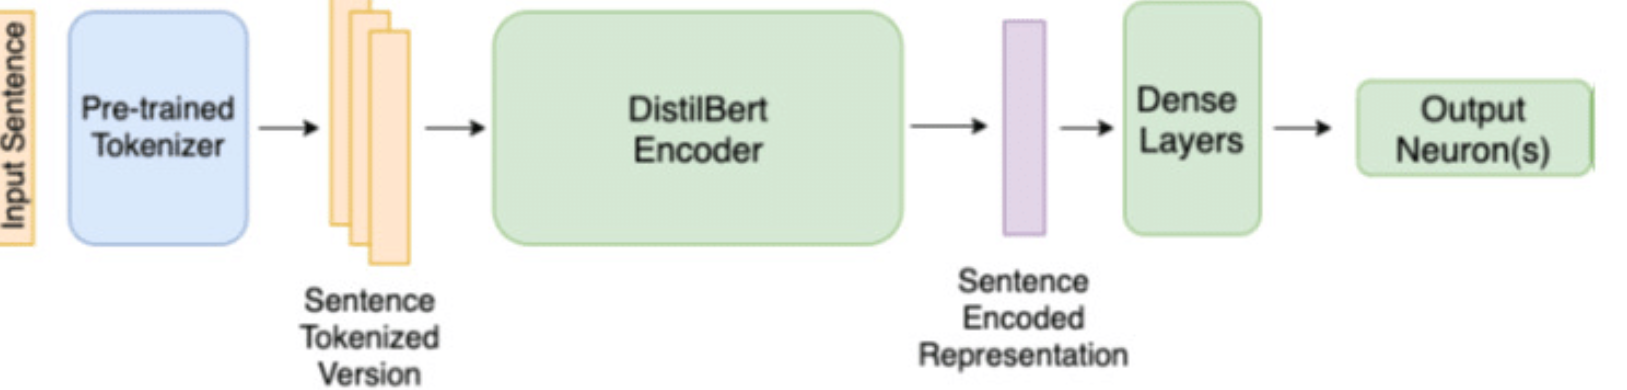

In [11]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

df_aug_ = df_aug[['text', 'intent_encoded']]

datasets_token = Dataset.from_pandas(df_aug_)

datasets_token = datasets_token.train_test_split(test_size=0.2)

datasets_token = datasets_token.map(tokenize, batched=True)

datasets_token = datasets_token.map(lambda x: {'labels': x['intent_encoded']})

Map: 100%|██████████| 48/48 [00:00<00:00, 4820.46 examples/s]


In [13]:
# saving csv's
train_df = datasets_token['train'].to_pandas()
test_df = datasets_token['test'].to_pandas()
train_df['intent'] = le.inverse_transform(train_df['intent_encoded'])
test_df['intent'] = le.inverse_transform(test_df['intent_encoded'])


train_df.to_csv('../../flask_back/rsc/datasets/train_aug.csv', index=False)
test_df.to_csv('../../flask_back/rsc/datasets/test_aug.csv', index=False)

# Fine-tuning 

In [206]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(df_aug['intent_encoded'].unique()))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets_token['train'],
    eval_dataset=datasets_token['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

eval_result = trainer.evaluate()
print(f"\n\n{eval_result}")

model.save_pretrained('bert_finetuned/model')
tokenizer.save_pretrained('bert_finetuned/tokenizer')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\thami\AppData\Local\Temp\ipykernel_30356\3115711115.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
                                                  
 63%|██████▎   | 756/1200 [22:03:45<04:17,  1.73it/s]

{'loss': 3.1232, 'grad_norm': 2.4800121784210205, 'learning_rate': 4.958333333333334e-05, 'epoch': 0.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                              

 63%|██████▎   | 756/1200 [22:03:47<04:17,  1.73it/s]



{'eval_loss': 3.0065243244171143, 'eval_accuracy': 0.3541666666666667, 'eval_f1': 0.2979983660130719, 'eval_precision': 0.30069444444444443, 'eval_recall': 0.3541666666666667, 'eval_runtime': 0.4924, 'eval_samples_per_second': 97.474, 'eval_steps_per_second': 6.092, 'epoch': 1.0}


                                                     
 63%|██████▎   | 756/1200 [22:03:55<04:17,  1.73it/s]

{'loss': 2.8569, 'grad_norm': 3.2573695182800293, 'learning_rate': 4.9166666666666665e-05, 'epoch': 1.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                              

 63%|██████▎   | 756/1200 [22:03:58<04:17,  1.73it/s]



{'eval_loss': 2.688741445541382, 'eval_accuracy': 0.4375, 'eval_f1': 0.3521164021164021, 'eval_precision': 0.32336309523809526, 'eval_recall': 0.4375, 'eval_runtime': 0.4374, 'eval_samples_per_second': 109.74, 'eval_steps_per_second': 6.859, 'epoch': 2.0}


                                                     
 63%|██████▎   | 756/1200 [22:04:03<04:17,  1.73it/s]

{'loss': 2.5265, 'grad_norm': 3.7432665824890137, 'learning_rate': 4.875e-05, 'epoch': 2.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                              

 63%|██████▎   | 756/1200 [22:04:08<04:17,  1.73it/s]



{'eval_loss': 2.2916667461395264, 'eval_accuracy': 0.5625, 'eval_f1': 0.520436507936508, 'eval_precision': 0.6055555555555555, 'eval_recall': 0.5625, 'eval_runtime': 0.4759, 'eval_samples_per_second': 100.863, 'eval_steps_per_second': 6.304, 'epoch': 3.0}


                                                     
 63%|██████▎   | 756/1200 [22:04:12<04:17,  1.73it/s]

{'loss': 2.1398, 'grad_norm': 3.6811892986297607, 'learning_rate': 4.8333333333333334e-05, 'epoch': 3.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                              

 63%|██████▎   | 756/1200 [22:04:19<04:17,  1.73it/s]



{'eval_loss': 1.9511109590530396, 'eval_accuracy': 0.6458333333333334, 'eval_f1': 0.6523809523809524, 'eval_precision': 0.8173611111111111, 'eval_recall': 0.6458333333333334, 'eval_runtime': 0.4547, 'eval_samples_per_second': 105.568, 'eval_steps_per_second': 6.598, 'epoch': 4.0}


                                                     
 63%|██████▎   | 756/1200 [22:04:21<04:17,  1.73it/s]

{'loss': 1.7354, 'grad_norm': 4.061933994293213, 'learning_rate': 4.791666666666667e-05, 'epoch': 4.17}


                                                     
 63%|██████▎   | 756/1200 [22:04:29<04:17,  1.73it/s]

{'loss': 1.3805, 'grad_norm': 3.577136754989624, 'learning_rate': 4.75e-05, 'epoch': 5.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                              

 63%|██████▎   | 756/1200 [22:04:29<04:17,  1.73it/s]



{'eval_loss': 1.584115982055664, 'eval_accuracy': 0.6875, 'eval_f1': 0.7023809523809524, 'eval_precision': 0.8489583333333334, 'eval_recall': 0.6875, 'eval_runtime': 0.4314, 'eval_samples_per_second': 111.256, 'eval_steps_per_second': 6.954, 'epoch': 5.0}


                                                     
 63%|██████▎   | 756/1200 [22:04:38<04:17,  1.73it/s]

{'loss': 1.0825, 'grad_norm': 3.299494504928589, 'learning_rate': 4.708333333333334e-05, 'epoch': 5.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                              

 63%|██████▎   | 756/1200 [22:04:40<04:17,  1.73it/s]



{'eval_loss': 1.3068089485168457, 'eval_accuracy': 0.7291666666666666, 'eval_f1': 0.7594696969696971, 'eval_precision': 0.890625, 'eval_recall': 0.7291666666666666, 'eval_runtime': 0.4648, 'eval_samples_per_second': 103.26, 'eval_steps_per_second': 6.454, 'epoch': 6.0}


                                                     
 63%|██████▎   | 756/1200 [22:04:55<04:17,  1.73it/s]

{'loss': 0.7895, 'grad_norm': 2.6745481491088867, 'learning_rate': 4.666666666666667e-05, 'epoch': 6.67}





c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                              

 63%|██████▎   | 756/1200 [22:05:00<04:17,  1.73it/s]



{'eval_loss': 1.0256131887435913, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8642316017316016, 'eval_precision': 0.9340277777777777, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.8339, 'eval_samples_per_second': 57.564, 'eval_steps_per_second': 3.598, 'epoch': 7.0}


                                                     
 63%|██████▎   | 756/1200 [22:05:09<04:17,  1.73it/s]

{'loss': 0.5685, 'grad_norm': 2.0821497440338135, 'learning_rate': 4.6250000000000006e-05, 'epoch': 7.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                              

 63%|██████▎   | 756/1200 [22:05:14<04:17,  1.73it/s]



{'eval_loss': 0.8304579257965088, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8468704906204906, 'eval_precision': 0.8958333333333334, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4656, 'eval_samples_per_second': 103.09, 'eval_steps_per_second': 6.443, 'epoch': 8.0}


                                                     
 63%|██████▎   | 756/1200 [22:05:18<04:17,  1.73it/s]

{'loss': 0.4392, 'grad_norm': 1.8935085535049438, 'learning_rate': 4.5833333333333334e-05, 'epoch': 8.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:05:25<04:17,  1.73it/s]



{'eval_loss': 0.6484737396240234, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8353174603174603, 'eval_precision': 0.8541666666666666, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4703, 'eval_samples_per_second': 102.052, 'eval_steps_per_second': 6.378, 'epoch': 9.0}


                                                     
 63%|██████▎   | 756/1200 [22:05:27<04:17,  1.73it/s]

{'loss': 0.2901, 'grad_norm': 1.4152960777282715, 'learning_rate': 4.541666666666667e-05, 'epoch': 9.17}


                                                     
 63%|██████▎   | 756/1200 [22:05:35<04:17,  1.73it/s]

{'loss': 0.2132, 'grad_norm': 1.388221263885498, 'learning_rate': 4.5e-05, 'epoch': 10.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:05:35<04:17,  1.73it/s]



{'eval_loss': 0.5594397187232971, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4943, 'eval_samples_per_second': 97.114, 'eval_steps_per_second': 6.07, 'epoch': 10.0}


                                                     
 63%|██████▎   | 756/1200 [22:05:44<04:17,  1.73it/s]

{'loss': 0.1456, 'grad_norm': 0.9601022005081177, 'learning_rate': 4.458333333333334e-05, 'epoch': 10.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:05:45<04:17,  1.73it/s]



{'eval_loss': 0.4585929811000824, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8443452380952382, 'eval_precision': 0.8888888888888888, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4832, 'eval_samples_per_second': 99.339, 'eval_steps_per_second': 6.209, 'epoch': 11.0}


                                                     
 63%|██████▎   | 756/1200 [22:05:52<04:17,  1.73it/s]

{'loss': 0.0949, 'grad_norm': 0.6545844674110413, 'learning_rate': 4.4166666666666665e-05, 'epoch': 11.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:05:56<04:17,  1.73it/s]



{'eval_loss': 0.4253286123275757, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4809, 'eval_samples_per_second': 99.808, 'eval_steps_per_second': 6.238, 'epoch': 12.0}


                                                     
 63%|██████▎   | 756/1200 [22:06:01<04:17,  1.73it/s]

{'loss': 0.0761, 'grad_norm': 0.4294244050979614, 'learning_rate': 4.375e-05, 'epoch': 12.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:06:06<04:17,  1.73it/s]



{'eval_loss': 0.38826456665992737, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.451, 'eval_samples_per_second': 106.423, 'eval_steps_per_second': 6.651, 'epoch': 13.0}


                                                     
 63%|██████▎   | 756/1200 [22:06:10<04:17,  1.73it/s]

{'loss': 0.0557, 'grad_norm': 0.3330737054347992, 'learning_rate': 4.3333333333333334e-05, 'epoch': 13.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:06:16<04:17,  1.73it/s]



{'eval_loss': 0.35025593638420105, 'eval_accuracy': 0.875, 'eval_f1': 0.876984126984127, 'eval_precision': 0.8993055555555555, 'eval_recall': 0.875, 'eval_runtime': 0.476, 'eval_samples_per_second': 100.847, 'eval_steps_per_second': 6.303, 'epoch': 14.0}


                                                     
 63%|██████▎   | 756/1200 [22:06:19<04:17,  1.73it/s]

{'loss': 0.0488, 'grad_norm': 0.34534192085266113, 'learning_rate': 4.291666666666667e-05, 'epoch': 14.17}


                                                     
 63%|██████▎   | 756/1200 [22:06:26<04:17,  1.73it/s]

{'loss': 0.0381, 'grad_norm': 0.24744883179664612, 'learning_rate': 4.25e-05, 'epoch': 15.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:06:27<04:17,  1.73it/s]



{'eval_loss': 0.36107099056243896, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4439, 'eval_samples_per_second': 108.138, 'eval_steps_per_second': 6.759, 'epoch': 15.0}


                                                     
 63%|██████▎   | 756/1200 [22:06:35<04:17,  1.73it/s]

{'loss': 0.0317, 'grad_norm': 0.23311442136764526, 'learning_rate': 4.208333333333334e-05, 'epoch': 15.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:06:37<04:17,  1.73it/s]



{'eval_loss': 0.34532955288887024, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5535, 'eval_samples_per_second': 86.714, 'eval_steps_per_second': 5.42, 'epoch': 16.0}


                                                     
 63%|██████▎   | 756/1200 [22:06:46<04:17,  1.73it/s]

{'loss': 0.0301, 'grad_norm': 0.3055837154388428, 'learning_rate': 4.166666666666667e-05, 'epoch': 16.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:06:50<04:17,  1.73it/s]



{'eval_loss': 0.33589863777160645, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5249, 'eval_samples_per_second': 91.444, 'eval_steps_per_second': 5.715, 'epoch': 17.0}


                                                     
 63%|██████▎   | 756/1200 [22:06:55<04:17,  1.73it/s]

{'loss': 0.0256, 'grad_norm': 0.16955557465553284, 'learning_rate': 4.125e-05, 'epoch': 17.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:07:01<04:17,  1.73it/s]



{'eval_loss': 0.349992036819458, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4729, 'eval_samples_per_second': 101.508, 'eval_steps_per_second': 6.344, 'epoch': 18.0}


                                                     
 63%|██████▎   | 756/1200 [22:07:06<04:17,  1.73it/s]

{'loss': 0.0245, 'grad_norm': 0.16793882846832275, 'learning_rate': 4.0833333333333334e-05, 'epoch': 18.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:07:13<04:17,  1.73it/s]



{'eval_loss': 0.3786437213420868, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5147, 'eval_samples_per_second': 93.263, 'eval_steps_per_second': 5.829, 'epoch': 19.0}


                                                     
 63%|██████▎   | 756/1200 [22:07:15<04:17,  1.73it/s]

{'loss': 0.0219, 'grad_norm': 0.1658896803855896, 'learning_rate': 4.041666666666667e-05, 'epoch': 19.17}


                                                     
 63%|██████▎   | 756/1200 [22:07:24<04:17,  1.73it/s]

{'loss': 0.0206, 'grad_norm': 0.17821581661701202, 'learning_rate': 4e-05, 'epoch': 20.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:07:24<04:17,  1.73it/s]



{'eval_loss': 0.3640851676464081, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4833, 'eval_samples_per_second': 99.325, 'eval_steps_per_second': 6.208, 'epoch': 20.0}


                                                     
 63%|██████▎   | 756/1200 [22:07:33<04:17,  1.73it/s]

{'loss': 0.0187, 'grad_norm': 0.17944331467151642, 'learning_rate': 3.958333333333333e-05, 'epoch': 20.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:07:35<04:17,  1.73it/s]



{'eval_loss': 0.3531562387943268, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5339, 'eval_samples_per_second': 89.909, 'eval_steps_per_second': 5.619, 'epoch': 21.0}


                                                     
 63%|██████▎   | 756/1200 [22:07:43<04:17,  1.73it/s]

{'loss': 0.0177, 'grad_norm': 0.16927504539489746, 'learning_rate': 3.9166666666666665e-05, 'epoch': 21.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:07:47<04:17,  1.73it/s]



{'eval_loss': 0.36343416571617126, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4559, 'eval_samples_per_second': 105.279, 'eval_steps_per_second': 6.58, 'epoch': 22.0}


                                                     
 63%|██████▎   | 756/1200 [22:07:52<04:17,  1.73it/s]

{'loss': 0.0153, 'grad_norm': 0.11088162660598755, 'learning_rate': 3.875e-05, 'epoch': 22.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:07:57<04:17,  1.73it/s]



{'eval_loss': 0.3408680260181427, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4987, 'eval_samples_per_second': 96.256, 'eval_steps_per_second': 6.016, 'epoch': 23.0}


                                                     
 63%|██████▎   | 756/1200 [22:08:01<04:17,  1.73it/s]

{'loss': 0.0139, 'grad_norm': 0.0934031531214714, 'learning_rate': 3.8333333333333334e-05, 'epoch': 23.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:08:07<04:17,  1.73it/s]



{'eval_loss': 0.33653339743614197, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4427, 'eval_samples_per_second': 108.415, 'eval_steps_per_second': 6.776, 'epoch': 24.0}


                                                     
 63%|██████▎   | 756/1200 [22:08:12<04:17,  1.73it/s]

{'loss': 0.0136, 'grad_norm': 0.09663256257772446, 'learning_rate': 3.791666666666667e-05, 'epoch': 24.17}


                                                     
 63%|██████▎   | 756/1200 [22:08:19<04:17,  1.73it/s]

{'loss': 0.0131, 'grad_norm': 0.09223490208387375, 'learning_rate': 3.7500000000000003e-05, 'epoch': 25.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:08:20<04:17,  1.73it/s]



{'eval_loss': 0.3465438783168793, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4588, 'eval_samples_per_second': 104.619, 'eval_steps_per_second': 6.539, 'epoch': 25.0}


                                                     
 63%|██████▎   | 756/1200 [22:08:28<04:17,  1.73it/s]

{'loss': 0.0128, 'grad_norm': 0.09042767435312271, 'learning_rate': 3.708333333333334e-05, 'epoch': 25.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:08:30<04:17,  1.73it/s]



{'eval_loss': 0.34767797589302063, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.459, 'eval_samples_per_second': 104.575, 'eval_steps_per_second': 6.536, 'epoch': 26.0}


                                                     
 63%|██████▎   | 756/1200 [22:08:37<04:17,  1.73it/s]

{'loss': 0.0117, 'grad_norm': 0.08143384009599686, 'learning_rate': 3.6666666666666666e-05, 'epoch': 26.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:08:40<04:17,  1.73it/s]



{'eval_loss': 0.34333956241607666, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4752, 'eval_samples_per_second': 101.015, 'eval_steps_per_second': 6.313, 'epoch': 27.0}


                                                     
 63%|██████▎   | 756/1200 [22:08:48<04:17,  1.73it/s]

{'loss': 0.0111, 'grad_norm': 0.09278960525989532, 'learning_rate': 3.625e-05, 'epoch': 27.5}





c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:08:53<04:17,  1.73it/s]



{'eval_loss': 0.3471251428127289, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.973, 'eval_samples_per_second': 49.33, 'eval_steps_per_second': 3.083, 'epoch': 28.0}


                                                     
 63%|██████▎   | 756/1200 [22:08:57<04:17,  1.73it/s]

{'loss': 0.0102, 'grad_norm': 0.08895377814769745, 'learning_rate': 3.5833333333333335e-05, 'epoch': 28.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:09:04<04:17,  1.73it/s]



{'eval_loss': 0.3420501947402954, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.477, 'eval_samples_per_second': 100.635, 'eval_steps_per_second': 6.29, 'epoch': 29.0}


                                                     
 63%|██████▎   | 756/1200 [22:09:08<04:17,  1.73it/s]

{'loss': 0.0095, 'grad_norm': 0.07951383292675018, 'learning_rate': 3.541666666666667e-05, 'epoch': 29.17}


                                                     
 63%|██████▎   | 756/1200 [22:09:15<04:17,  1.73it/s]

{'loss': 0.0092, 'grad_norm': 0.10848070681095123, 'learning_rate': 3.5e-05, 'epoch': 30.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:09:16<04:17,  1.73it/s]



{'eval_loss': 0.33651435375213623, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4701, 'eval_samples_per_second': 102.097, 'eval_steps_per_second': 6.381, 'epoch': 30.0}


                                                     
 63%|██████▎   | 756/1200 [22:09:26<04:17,  1.73it/s]

{'loss': 0.0089, 'grad_norm': 0.05522870272397995, 'learning_rate': 3.458333333333333e-05, 'epoch': 30.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:09:28<04:17,  1.73it/s]



{'eval_loss': 0.334583044052124, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5155, 'eval_samples_per_second': 93.106, 'eval_steps_per_second': 5.819, 'epoch': 31.0}


                                                     
 63%|██████▎   | 756/1200 [22:09:38<04:17,  1.73it/s]

{'loss': 0.0086, 'grad_norm': 0.07023099064826965, 'learning_rate': 3.4166666666666666e-05, 'epoch': 31.67}





c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:09:44<04:17,  1.73it/s]



{'eval_loss': 0.3317720890045166, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 1.296, 'eval_samples_per_second': 37.037, 'eval_steps_per_second': 2.315, 'epoch': 32.0}


                                                     
 63%|██████▎   | 756/1200 [22:09:59<04:17,  1.73it/s]

{'loss': 0.0086, 'grad_norm': 0.06877390295267105, 'learning_rate': 3.375000000000001e-05, 'epoch': 32.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:10:05<04:17,  1.73it/s]



{'eval_loss': 0.3358403742313385, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.479, 'eval_samples_per_second': 100.217, 'eval_steps_per_second': 6.264, 'epoch': 33.0}


                                                     
 63%|██████▎   | 756/1200 [22:10:11<04:17,  1.73it/s]

{'loss': 0.0082, 'grad_norm': 0.05242214724421501, 'learning_rate': 3.3333333333333335e-05, 'epoch': 33.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:10:18<04:17,  1.73it/s]



{'eval_loss': 0.33857443928718567, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5145, 'eval_samples_per_second': 93.285, 'eval_steps_per_second': 5.83, 'epoch': 34.0}


                                                     
 63%|██████▎   | 756/1200 [22:10:22<04:17,  1.73it/s]

{'loss': 0.008, 'grad_norm': 0.06726711243391037, 'learning_rate': 3.291666666666667e-05, 'epoch': 34.17}


                                                     
 63%|██████▎   | 756/1200 [22:10:30<04:17,  1.73it/s]

{'loss': 0.0074, 'grad_norm': 0.053734198212623596, 'learning_rate': 3.2500000000000004e-05, 'epoch': 35.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:10:30<04:17,  1.73it/s]



{'eval_loss': 0.33728739619255066, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4719, 'eval_samples_per_second': 101.707, 'eval_steps_per_second': 6.357, 'epoch': 35.0}


                                                     
 63%|██████▎   | 756/1200 [22:10:40<04:17,  1.73it/s]

{'loss': 0.0072, 'grad_norm': 0.059164129197597504, 'learning_rate': 3.208333333333334e-05, 'epoch': 35.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:10:42<04:17,  1.73it/s]



{'eval_loss': 0.3375494182109833, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4842, 'eval_samples_per_second': 99.133, 'eval_steps_per_second': 6.196, 'epoch': 36.0}


                                                     
 63%|██████▎   | 756/1200 [22:10:52<04:17,  1.73it/s]

{'loss': 0.0067, 'grad_norm': 0.0670219212770462, 'learning_rate': 3.1666666666666666e-05, 'epoch': 36.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:10:55<04:17,  1.73it/s]



{'eval_loss': 0.34392985701560974, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4777, 'eval_samples_per_second': 100.489, 'eval_steps_per_second': 6.281, 'epoch': 37.0}


                                                     
 63%|██████▎   | 756/1200 [22:11:03<04:17,  1.73it/s]

{'loss': 0.0065, 'grad_norm': 0.05716675892472267, 'learning_rate': 3.125e-05, 'epoch': 37.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:11:08<04:17,  1.73it/s]



{'eval_loss': 0.3501206934452057, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4728, 'eval_samples_per_second': 101.526, 'eval_steps_per_second': 6.345, 'epoch': 38.0}


                                                     
 63%|██████▎   | 756/1200 [22:11:14<04:17,  1.73it/s]

{'loss': 0.0071, 'grad_norm': 0.06030276045203209, 'learning_rate': 3.0833333333333335e-05, 'epoch': 38.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:11:20<04:17,  1.73it/s]



{'eval_loss': 0.3479672968387604, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4911, 'eval_samples_per_second': 97.737, 'eval_steps_per_second': 6.109, 'epoch': 39.0}


                                                     
 63%|██████▎   | 756/1200 [22:11:25<04:17,  1.73it/s]

{'loss': 0.0064, 'grad_norm': 0.04454968124628067, 'learning_rate': 3.0416666666666666e-05, 'epoch': 39.17}


                                                     
 63%|██████▎   | 756/1200 [22:11:33<04:17,  1.73it/s]

{'loss': 0.0061, 'grad_norm': 0.049906179308891296, 'learning_rate': 3e-05, 'epoch': 40.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:11:34<04:17,  1.73it/s]



{'eval_loss': 0.3460358679294586, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4724, 'eval_samples_per_second': 101.607, 'eval_steps_per_second': 6.35, 'epoch': 40.0}


                                                     
 63%|██████▎   | 756/1200 [22:11:44<04:17,  1.73it/s]

{'loss': 0.0059, 'grad_norm': 0.05334482342004776, 'learning_rate': 2.9583333333333335e-05, 'epoch': 40.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:11:46<04:17,  1.73it/s]



{'eval_loss': 0.3476436138153076, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4756, 'eval_samples_per_second': 100.935, 'eval_steps_per_second': 6.308, 'epoch': 41.0}


                                                     
 63%|██████▎   | 756/1200 [22:11:59<04:17,  1.73it/s]

{'loss': 0.0057, 'grad_norm': 0.03897210583090782, 'learning_rate': 2.916666666666667e-05, 'epoch': 41.67}





c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:12:02<04:17,  1.73it/s]



{'eval_loss': 0.3512222468852997, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.555, 'eval_samples_per_second': 86.492, 'eval_steps_per_second': 5.406, 'epoch': 42.0}


                                                     
 63%|██████▎   | 756/1200 [22:12:10<04:17,  1.73it/s]

{'loss': 0.0054, 'grad_norm': 0.041280731558799744, 'learning_rate': 2.8749999999999997e-05, 'epoch': 42.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:12:14<04:17,  1.73it/s]



{'eval_loss': 0.35468974709510803, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4713, 'eval_samples_per_second': 101.842, 'eval_steps_per_second': 6.365, 'epoch': 43.0}


                                                     
 63%|██████▎   | 756/1200 [22:12:20<04:17,  1.73it/s]

{'loss': 0.0056, 'grad_norm': 0.05509718507528305, 'learning_rate': 2.8333333333333335e-05, 'epoch': 43.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:12:26<04:17,  1.73it/s]



{'eval_loss': 0.3520186245441437, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4612, 'eval_samples_per_second': 104.071, 'eval_steps_per_second': 6.504, 'epoch': 44.0}


                                                     
 63%|██████▎   | 756/1200 [22:12:31<04:17,  1.73it/s]

{'loss': 0.0049, 'grad_norm': 0.04530206695199013, 'learning_rate': 2.791666666666667e-05, 'epoch': 44.17}


                                                     
 63%|██████▎   | 756/1200 [22:12:38<04:17,  1.73it/s]

{'loss': 0.0051, 'grad_norm': 0.03770867735147476, 'learning_rate': 2.7500000000000004e-05, 'epoch': 45.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:12:39<04:17,  1.73it/s]



{'eval_loss': 0.34783196449279785, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4714, 'eval_samples_per_second': 101.815, 'eval_steps_per_second': 6.363, 'epoch': 45.0}


                                                     
 63%|██████▎   | 756/1200 [22:12:51<04:17,  1.73it/s]

{'loss': 0.0049, 'grad_norm': 0.03999185189604759, 'learning_rate': 2.7083333333333332e-05, 'epoch': 45.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:12:53<04:17,  1.73it/s]



{'eval_loss': 0.3488764762878418, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.461, 'eval_samples_per_second': 104.128, 'eval_steps_per_second': 6.508, 'epoch': 46.0}


                                                     
 63%|██████▎   | 756/1200 [22:13:02<04:17,  1.73it/s]

{'loss': 0.0047, 'grad_norm': 0.043021466583013535, 'learning_rate': 2.6666666666666667e-05, 'epoch': 46.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:13:06<04:17,  1.73it/s]



{'eval_loss': 0.34850165247917175, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4964, 'eval_samples_per_second': 96.692, 'eval_steps_per_second': 6.043, 'epoch': 47.0}


                                                     
 63%|██████▎   | 756/1200 [22:13:13<04:17,  1.73it/s]

{'loss': 0.0048, 'grad_norm': 0.046717457473278046, 'learning_rate': 2.625e-05, 'epoch': 47.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:13:18<04:17,  1.73it/s]



{'eval_loss': 0.3501676023006439, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4717, 'eval_samples_per_second': 101.752, 'eval_steps_per_second': 6.36, 'epoch': 48.0}


                                                     
 63%|██████▎   | 756/1200 [22:13:24<04:17,  1.73it/s]

{'loss': 0.0046, 'grad_norm': 0.04927090182900429, 'learning_rate': 2.5833333333333336e-05, 'epoch': 48.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:13:30<04:17,  1.73it/s]



{'eval_loss': 0.35650086402893066, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4399, 'eval_samples_per_second': 109.128, 'eval_steps_per_second': 6.82, 'epoch': 49.0}


                                                     
 63%|██████▎   | 756/1200 [22:13:34<04:17,  1.73it/s]

{'loss': 0.0045, 'grad_norm': 0.03541935980319977, 'learning_rate': 2.5416666666666667e-05, 'epoch': 49.17}


                                                     
 63%|██████▎   | 756/1200 [22:13:42<04:17,  1.73it/s]

{'loss': 0.0043, 'grad_norm': 0.04338662698864937, 'learning_rate': 2.5e-05, 'epoch': 50.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:13:42<04:17,  1.73it/s]



{'eval_loss': 0.357717365026474, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4842, 'eval_samples_per_second': 99.139, 'eval_steps_per_second': 6.196, 'epoch': 50.0}


                                                     
 63%|██████▎   | 756/1200 [22:13:52<04:17,  1.73it/s]

{'loss': 0.0042, 'grad_norm': 0.027540141716599464, 'learning_rate': 2.4583333333333332e-05, 'epoch': 50.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:13:54<04:17,  1.73it/s]



{'eval_loss': 0.36346521973609924, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4822, 'eval_samples_per_second': 99.541, 'eval_steps_per_second': 6.221, 'epoch': 51.0}


                                                     
 63%|██████▎   | 756/1200 [22:14:03<04:17,  1.73it/s]

{'loss': 0.0042, 'grad_norm': 0.037019282579422, 'learning_rate': 2.4166666666666667e-05, 'epoch': 51.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:14:07<04:17,  1.73it/s]



{'eval_loss': 0.3642731010913849, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4535, 'eval_samples_per_second': 105.839, 'eval_steps_per_second': 6.615, 'epoch': 52.0}


                                                     
 63%|██████▎   | 756/1200 [22:14:14<04:17,  1.73it/s]

{'loss': 0.0041, 'grad_norm': 0.03408334404230118, 'learning_rate': 2.375e-05, 'epoch': 52.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:14:19<04:17,  1.73it/s]



{'eval_loss': 0.360694020986557, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4417, 'eval_samples_per_second': 108.669, 'eval_steps_per_second': 6.792, 'epoch': 53.0}


                                                     
 63%|██████▎   | 756/1200 [22:14:25<04:17,  1.73it/s]

{'loss': 0.0041, 'grad_norm': 0.03501003980636597, 'learning_rate': 2.3333333333333336e-05, 'epoch': 53.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:14:31<04:17,  1.73it/s]



{'eval_loss': 0.35565197467803955, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.482, 'eval_samples_per_second': 99.586, 'eval_steps_per_second': 6.224, 'epoch': 54.0}


                                                     
 63%|██████▎   | 756/1200 [22:14:35<04:17,  1.73it/s]

{'loss': 0.0036, 'grad_norm': 0.02802981249988079, 'learning_rate': 2.2916666666666667e-05, 'epoch': 54.17}


                                                     
 63%|██████▎   | 756/1200 [22:14:42<04:17,  1.73it/s]

{'loss': 0.0038, 'grad_norm': 0.03359605371952057, 'learning_rate': 2.25e-05, 'epoch': 55.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:14:43<04:17,  1.73it/s]



{'eval_loss': 0.35404470562934875, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5057, 'eval_samples_per_second': 94.917, 'eval_steps_per_second': 5.932, 'epoch': 55.0}


                                                     
 63%|██████▎   | 756/1200 [22:14:53<04:17,  1.73it/s]

{'loss': 0.0038, 'grad_norm': 0.024113567546010017, 'learning_rate': 2.2083333333333333e-05, 'epoch': 55.83}





c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:14:55<04:17,  1.73it/s]



{'eval_loss': 0.3560272753238678, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5336, 'eval_samples_per_second': 89.948, 'eval_steps_per_second': 5.622, 'epoch': 56.0}


                                                     
 63%|██████▎   | 756/1200 [22:15:04<04:17,  1.73it/s]

{'loss': 0.0036, 'grad_norm': 0.034838464111089706, 'learning_rate': 2.1666666666666667e-05, 'epoch': 56.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:15:07<04:17,  1.73it/s]



{'eval_loss': 0.35791921615600586, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4628, 'eval_samples_per_second': 103.718, 'eval_steps_per_second': 6.482, 'epoch': 57.0}


                                                     
 63%|██████▎   | 756/1200 [22:15:14<04:17,  1.73it/s]

{'loss': 0.0037, 'grad_norm': 0.02977096475660801, 'learning_rate': 2.125e-05, 'epoch': 57.5}





c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:15:19<04:17,  1.73it/s]



{'eval_loss': 0.3664356768131256, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.5978, 'eval_samples_per_second': 80.3, 'eval_steps_per_second': 5.019, 'epoch': 58.0}


                                                     
 63%|██████▎   | 756/1200 [22:15:25<04:17,  1.73it/s]

{'loss': 0.0036, 'grad_norm': 0.03354090452194214, 'learning_rate': 2.0833333333333336e-05, 'epoch': 58.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:15:32<04:17,  1.73it/s]



{'eval_loss': 0.36539986729621887, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4855, 'eval_samples_per_second': 98.863, 'eval_steps_per_second': 6.179, 'epoch': 59.0}


                                                     
 63%|██████▎   | 756/1200 [22:15:36<04:17,  1.73it/s]

{'loss': 0.0036, 'grad_norm': 0.02756367437541485, 'learning_rate': 2.0416666666666667e-05, 'epoch': 59.17}


                                                     
 63%|██████▎   | 756/1200 [22:15:43<04:17,  1.73it/s]

{'loss': 0.0035, 'grad_norm': 0.028148343786597252, 'learning_rate': 2e-05, 'epoch': 60.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:15:44<04:17,  1.73it/s]



{'eval_loss': 0.36257147789001465, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4644, 'eval_samples_per_second': 103.363, 'eval_steps_per_second': 6.46, 'epoch': 60.0}


                                                     
 63%|██████▎   | 756/1200 [22:15:54<04:17,  1.73it/s]

{'loss': 0.0035, 'grad_norm': 0.03463377431035042, 'learning_rate': 1.9583333333333333e-05, 'epoch': 60.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:15:56<04:17,  1.73it/s]



{'eval_loss': 0.36046895384788513, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4743, 'eval_samples_per_second': 101.211, 'eval_steps_per_second': 6.326, 'epoch': 61.0}


                                                     
 63%|██████▎   | 756/1200 [22:16:06<04:17,  1.73it/s]

{'loss': 0.0035, 'grad_norm': 0.02751254290342331, 'learning_rate': 1.9166666666666667e-05, 'epoch': 61.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:16:10<04:17,  1.73it/s]



{'eval_loss': 0.3575613796710968, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4705, 'eval_samples_per_second': 102.011, 'eval_steps_per_second': 6.376, 'epoch': 62.0}


                                                     
 63%|██████▎   | 756/1200 [22:16:17<04:17,  1.73it/s]

{'loss': 0.0031, 'grad_norm': 0.029686279594898224, 'learning_rate': 1.8750000000000002e-05, 'epoch': 62.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:16:22<04:17,  1.73it/s]



{'eval_loss': 0.3547007739543915, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5882, 'eval_samples_per_second': 81.601, 'eval_steps_per_second': 5.1, 'epoch': 63.0}


                                                     
 63%|██████▎   | 756/1200 [22:16:28<04:17,  1.73it/s]

{'loss': 0.0035, 'grad_norm': 0.03441040962934494, 'learning_rate': 1.8333333333333333e-05, 'epoch': 63.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:16:36<04:17,  1.73it/s]



{'eval_loss': 0.3549552857875824, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5293, 'eval_samples_per_second': 90.681, 'eval_steps_per_second': 5.668, 'epoch': 64.0}


                                                     
 63%|██████▎   | 756/1200 [22:16:40<04:17,  1.73it/s]

{'loss': 0.0032, 'grad_norm': 0.03369130194187164, 'learning_rate': 1.7916666666666667e-05, 'epoch': 64.17}


                                                     
 63%|██████▎   | 756/1200 [22:16:48<04:17,  1.73it/s]

{'loss': 0.0032, 'grad_norm': 0.020367475226521492, 'learning_rate': 1.75e-05, 'epoch': 65.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:16:48<04:17,  1.73it/s]



{'eval_loss': 0.3573141396045685, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4854, 'eval_samples_per_second': 98.883, 'eval_steps_per_second': 6.18, 'epoch': 65.0}


                                                     
 63%|██████▎   | 756/1200 [22:16:58<04:17,  1.73it/s]

{'loss': 0.003, 'grad_norm': 0.023722365498542786, 'learning_rate': 1.7083333333333333e-05, 'epoch': 65.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:17:00<04:17,  1.73it/s]



{'eval_loss': 0.3574488162994385, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4966, 'eval_samples_per_second': 96.657, 'eval_steps_per_second': 6.041, 'epoch': 66.0}


                                                     
 63%|██████▎   | 756/1200 [22:17:09<04:17,  1.73it/s]

{'loss': 0.0032, 'grad_norm': 0.025124238803982735, 'learning_rate': 1.6666666666666667e-05, 'epoch': 66.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:17:12<04:17,  1.73it/s]



{'eval_loss': 0.35845234990119934, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5224, 'eval_samples_per_second': 91.875, 'eval_steps_per_second': 5.742, 'epoch': 67.0}


                                                     
 63%|██████▎   | 756/1200 [22:17:20<04:17,  1.73it/s]

{'loss': 0.0032, 'grad_norm': 0.027113141492009163, 'learning_rate': 1.6250000000000002e-05, 'epoch': 67.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:17:25<04:17,  1.73it/s]



{'eval_loss': 0.3591900169849396, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4899, 'eval_samples_per_second': 97.986, 'eval_steps_per_second': 6.124, 'epoch': 68.0}


                                                     
 63%|██████▎   | 756/1200 [22:17:31<04:17,  1.73it/s]

{'loss': 0.003, 'grad_norm': 0.023524118587374687, 'learning_rate': 1.5833333333333333e-05, 'epoch': 68.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:17:42<04:17,  1.73it/s]



{'eval_loss': 0.3639095723628998, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5874, 'eval_samples_per_second': 81.717, 'eval_steps_per_second': 5.107, 'epoch': 69.0}


                                                     
 63%|██████▎   | 756/1200 [22:17:46<04:17,  1.73it/s]

{'loss': 0.003, 'grad_norm': 0.030142614617943764, 'learning_rate': 1.5416666666666668e-05, 'epoch': 69.17}


                                                     
 63%|██████▎   | 756/1200 [22:17:54<04:17,  1.73it/s]

{'loss': 0.0028, 'grad_norm': 0.023260291665792465, 'learning_rate': 1.5e-05, 'epoch': 70.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:17:54<04:17,  1.73it/s]



{'eval_loss': 0.36364391446113586, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5005, 'eval_samples_per_second': 95.908, 'eval_steps_per_second': 5.994, 'epoch': 70.0}


                                                     
 63%|██████▎   | 756/1200 [22:18:06<04:17,  1.73it/s]

{'loss': 0.0028, 'grad_norm': 0.020098159089684486, 'learning_rate': 1.4583333333333335e-05, 'epoch': 70.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:18:08<04:17,  1.73it/s]



{'eval_loss': 0.36176666617393494, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4633, 'eval_samples_per_second': 103.598, 'eval_steps_per_second': 6.475, 'epoch': 71.0}


                                                     
 63%|██████▎   | 756/1200 [22:18:19<04:17,  1.73it/s]

{'loss': 0.0029, 'grad_norm': 0.023219436407089233, 'learning_rate': 1.4166666666666668e-05, 'epoch': 71.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:18:23<04:17,  1.73it/s]



{'eval_loss': 0.3639768064022064, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5064, 'eval_samples_per_second': 94.782, 'eval_steps_per_second': 5.924, 'epoch': 72.0}


                                                     
 63%|██████▎   | 756/1200 [22:18:31<04:17,  1.73it/s]

{'loss': 0.0027, 'grad_norm': 0.02353569120168686, 'learning_rate': 1.3750000000000002e-05, 'epoch': 72.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:18:36<04:17,  1.73it/s]



{'eval_loss': 0.3671020567417145, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5034, 'eval_samples_per_second': 95.357, 'eval_steps_per_second': 5.96, 'epoch': 73.0}


                                                     
 63%|██████▎   | 756/1200 [22:18:42<04:17,  1.73it/s]

{'loss': 0.0028, 'grad_norm': 0.02331836335361004, 'learning_rate': 1.3333333333333333e-05, 'epoch': 73.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:18:49<04:17,  1.73it/s]



{'eval_loss': 0.36937716603279114, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5278, 'eval_samples_per_second': 90.948, 'eval_steps_per_second': 5.684, 'epoch': 74.0}


                                                     
 63%|██████▎   | 756/1200 [22:18:53<04:17,  1.73it/s]

{'loss': 0.0028, 'grad_norm': 0.028003422543406487, 'learning_rate': 1.2916666666666668e-05, 'epoch': 74.17}


                                                     
 63%|██████▎   | 756/1200 [22:19:01<04:17,  1.73it/s]

{'loss': 0.0027, 'grad_norm': 0.025058837607502937, 'learning_rate': 1.25e-05, 'epoch': 75.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:19:01<04:17,  1.73it/s]



{'eval_loss': 0.37044474482536316, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4923, 'eval_samples_per_second': 97.501, 'eval_steps_per_second': 6.094, 'epoch': 75.0}


                                                     
 63%|██████▎   | 756/1200 [22:19:10<04:17,  1.73it/s]

{'loss': 0.0027, 'grad_norm': 0.027841005474328995, 'learning_rate': 1.2083333333333333e-05, 'epoch': 75.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:19:12<04:17,  1.73it/s]



{'eval_loss': 0.3698699474334717, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4922, 'eval_samples_per_second': 97.519, 'eval_steps_per_second': 6.095, 'epoch': 76.0}


                                                     
 63%|██████▎   | 756/1200 [22:19:21<04:17,  1.73it/s]

{'loss': 0.0026, 'grad_norm': 0.019455719739198685, 'learning_rate': 1.1666666666666668e-05, 'epoch': 76.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:19:24<04:17,  1.73it/s]



{'eval_loss': 0.36913809180259705, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4985, 'eval_samples_per_second': 96.291, 'eval_steps_per_second': 6.018, 'epoch': 77.0}


                                                     
 63%|██████▎   | 756/1200 [22:19:31<04:17,  1.73it/s]

{'loss': 0.0025, 'grad_norm': 0.024123799055814743, 'learning_rate': 1.125e-05, 'epoch': 77.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:19:36<04:17,  1.73it/s]



{'eval_loss': 0.36921024322509766, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4601, 'eval_samples_per_second': 104.315, 'eval_steps_per_second': 6.52, 'epoch': 78.0}


                                                     
 63%|██████▎   | 756/1200 [22:19:42<04:17,  1.73it/s]

{'loss': 0.0027, 'grad_norm': 0.018405308946967125, 'learning_rate': 1.0833333333333334e-05, 'epoch': 78.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:19:48<04:17,  1.73it/s]



{'eval_loss': 0.36895909905433655, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4607, 'eval_samples_per_second': 104.187, 'eval_steps_per_second': 6.512, 'epoch': 79.0}


                                                     
 63%|██████▎   | 756/1200 [22:19:53<04:17,  1.73it/s]

{'loss': 0.0026, 'grad_norm': 0.019639823585748672, 'learning_rate': 1.0416666666666668e-05, 'epoch': 79.17}


                                                     
 63%|██████▎   | 756/1200 [22:20:01<04:17,  1.73it/s]

{'loss': 0.0027, 'grad_norm': 0.027989549562335014, 'learning_rate': 1e-05, 'epoch': 80.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:20:01<04:17,  1.73it/s]



{'eval_loss': 0.3678523600101471, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4826, 'eval_samples_per_second': 99.452, 'eval_steps_per_second': 6.216, 'epoch': 80.0}


                                                     
 63%|██████▎   | 756/1200 [22:20:12<04:17,  1.73it/s]

{'loss': 0.0025, 'grad_norm': 0.017001530155539513, 'learning_rate': 9.583333333333334e-06, 'epoch': 80.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:20:14<04:17,  1.73it/s]



{'eval_loss': 0.3686666190624237, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4945, 'eval_samples_per_second': 97.067, 'eval_steps_per_second': 6.067, 'epoch': 81.0}


                                                     
 63%|██████▎   | 756/1200 [22:20:23<04:17,  1.73it/s]

{'loss': 0.0025, 'grad_norm': 0.028285769745707512, 'learning_rate': 9.166666666666666e-06, 'epoch': 81.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:20:26<04:17,  1.73it/s]



{'eval_loss': 0.36863431334495544, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.5038, 'eval_samples_per_second': 95.279, 'eval_steps_per_second': 5.955, 'epoch': 82.0}


                                                     
 63%|██████▎   | 756/1200 [22:20:34<04:17,  1.73it/s]

{'loss': 0.0026, 'grad_norm': 0.02127566747367382, 'learning_rate': 8.75e-06, 'epoch': 82.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                               

 63%|██████▎   | 756/1200 [22:20:39<04:17,  1.73it/s]



{'eval_loss': 0.3681112229824066, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4604, 'eval_samples_per_second': 104.265, 'eval_steps_per_second': 6.517, 'epoch': 83.0}


                                                     
 63%|██████▎   | 756/1200 [22:20:46<04:17,  1.73it/s]

{'loss': 0.0025, 'grad_norm': 0.01873033307492733, 'learning_rate': 8.333333333333334e-06, 'epoch': 83.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:20:53<04:17,  1.73it/s]



{'eval_loss': 0.36674240231513977, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4872, 'eval_samples_per_second': 98.529, 'eval_steps_per_second': 6.158, 'epoch': 84.0}


                                                     
 63%|██████▎   | 756/1200 [22:20:58<04:17,  1.73it/s]

{'loss': 0.0026, 'grad_norm': 0.0202633049339056, 'learning_rate': 7.916666666666667e-06, 'epoch': 84.17}


                                                     
 63%|██████▎   | 756/1200 [22:21:05<04:17,  1.73it/s]

{'loss': 0.0026, 'grad_norm': 0.026224419474601746, 'learning_rate': 7.5e-06, 'epoch': 85.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:21:06<04:17,  1.73it/s]



{'eval_loss': 0.36510804295539856, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.4686, 'eval_samples_per_second': 102.441, 'eval_steps_per_second': 6.403, 'epoch': 85.0}


                                                     
 63%|██████▎   | 756/1200 [22:21:19<04:17,  1.73it/s]

{'loss': 0.0024, 'grad_norm': 0.021240681409835815, 'learning_rate': 7.083333333333334e-06, 'epoch': 85.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:21:21<04:17,  1.73it/s]



{'eval_loss': 0.3632560074329376, 'eval_accuracy': 0.8541666666666666, 'eval_f1': 0.8526785714285715, 'eval_precision': 0.892361111111111, 'eval_recall': 0.8541666666666666, 'eval_runtime': 0.5171, 'eval_samples_per_second': 92.825, 'eval_steps_per_second': 5.802, 'epoch': 86.0}


                                                     
 63%|██████▎   | 756/1200 [22:21:30<04:17,  1.73it/s]

{'loss': 0.0023, 'grad_norm': 0.02279512770473957, 'learning_rate': 6.666666666666667e-06, 'epoch': 86.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:21:33<04:17,  1.73it/s]



{'eval_loss': 0.363533616065979, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.5108, 'eval_samples_per_second': 93.964, 'eval_steps_per_second': 5.873, 'epoch': 87.0}


                                                     
 63%|██████▎   | 756/1200 [22:21:41<04:17,  1.73it/s]

{'loss': 0.0026, 'grad_norm': 0.02533421479165554, 'learning_rate': 6.25e-06, 'epoch': 87.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:21:46<04:17,  1.73it/s]



{'eval_loss': 0.36430418491363525, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4848, 'eval_samples_per_second': 99.014, 'eval_steps_per_second': 6.188, 'epoch': 88.0}


                                                     
 63%|██████▎   | 756/1200 [22:21:52<04:17,  1.73it/s]

{'loss': 0.0024, 'grad_norm': 0.020570222288370132, 'learning_rate': 5.833333333333334e-06, 'epoch': 88.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:21:59<04:17,  1.73it/s]



{'eval_loss': 0.3642791211605072, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.5248, 'eval_samples_per_second': 91.46, 'eval_steps_per_second': 5.716, 'epoch': 89.0}


                                                     
 63%|██████▎   | 756/1200 [22:22:06<04:17,  1.73it/s]

{'loss': 0.0024, 'grad_norm': 0.023241695016622543, 'learning_rate': 5.416666666666667e-06, 'epoch': 89.17}


                                                     
 63%|██████▎   | 756/1200 [22:22:14<04:17,  1.73it/s]

{'loss': 0.0024, 'grad_norm': 0.020595906302332878, 'learning_rate': 5e-06, 'epoch': 90.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:22:14<04:17,  1.73it/s]



{'eval_loss': 0.3645532429218292, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.5157, 'eval_samples_per_second': 93.072, 'eval_steps_per_second': 5.817, 'epoch': 90.0}


                                                     
 63%|██████▎   | 756/1200 [22:22:28<04:17,  1.73it/s]

{'loss': 0.0025, 'grad_norm': 0.02247856929898262, 'learning_rate': 4.583333333333333e-06, 'epoch': 90.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:22:30<04:17,  1.73it/s]



{'eval_loss': 0.364185094833374, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4734, 'eval_samples_per_second': 101.395, 'eval_steps_per_second': 6.337, 'epoch': 91.0}


                                                     
 63%|██████▎   | 756/1200 [22:22:41<04:17,  1.73it/s]

{'loss': 0.0023, 'grad_norm': 0.017405536025762558, 'learning_rate': 4.166666666666667e-06, 'epoch': 91.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:22:45<04:17,  1.73it/s]



{'eval_loss': 0.3647533357143402, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.454, 'eval_samples_per_second': 105.723, 'eval_steps_per_second': 6.608, 'epoch': 92.0}


                                                     
 63%|██████▎   | 756/1200 [22:22:54<04:17,  1.73it/s]

{'loss': 0.0025, 'grad_norm': 0.02254779264330864, 'learning_rate': 3.75e-06, 'epoch': 92.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:23:00<04:17,  1.73it/s]



{'eval_loss': 0.36468639969825745, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.5176, 'eval_samples_per_second': 92.736, 'eval_steps_per_second': 5.796, 'epoch': 93.0}


                                                     
 63%|██████▎   | 756/1200 [22:23:06<04:17,  1.73it/s]

{'loss': 0.0025, 'grad_norm': 0.02134088985621929, 'learning_rate': 3.3333333333333333e-06, 'epoch': 93.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:23:13<04:17,  1.73it/s]



{'eval_loss': 0.3643517792224884, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4733, 'eval_samples_per_second': 101.424, 'eval_steps_per_second': 6.339, 'epoch': 94.0}


                                                     
 63%|██████▎   | 756/1200 [22:23:17<04:17,  1.73it/s]

{'loss': 0.0027, 'grad_norm': 0.02307666651904583, 'learning_rate': 2.916666666666667e-06, 'epoch': 94.17}


                                                     
 63%|██████▎   | 756/1200 [22:23:25<04:17,  1.73it/s]

{'loss': 0.0024, 'grad_norm': 0.019865475594997406, 'learning_rate': 2.5e-06, 'epoch': 95.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:23:25<04:17,  1.73it/s]



{'eval_loss': 0.3637024164199829, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4885, 'eval_samples_per_second': 98.265, 'eval_steps_per_second': 6.142, 'epoch': 95.0}


                                                     
 63%|██████▎   | 756/1200 [22:23:36<04:17,  1.73it/s]

{'loss': 0.0022, 'grad_norm': 0.022070616483688354, 'learning_rate': 2.0833333333333334e-06, 'epoch': 95.83}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:23:38<04:17,  1.73it/s]



{'eval_loss': 0.3638765513896942, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.5022, 'eval_samples_per_second': 95.581, 'eval_steps_per_second': 5.974, 'epoch': 96.0}


                                                     
 63%|██████▎   | 756/1200 [22:23:51<04:17,  1.73it/s]

{'loss': 0.0024, 'grad_norm': 0.017598651349544525, 'learning_rate': 1.6666666666666667e-06, 'epoch': 96.67}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:23:56<04:17,  1.73it/s]



{'eval_loss': 0.3640260696411133, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4938, 'eval_samples_per_second': 97.208, 'eval_steps_per_second': 6.075, 'epoch': 97.0}


                                                     
 63%|██████▎   | 756/1200 [22:24:01<04:17,  1.73it/s]

{'loss': 0.0024, 'grad_norm': 0.03469781205058098, 'learning_rate': 1.25e-06, 'epoch': 97.5}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:24:06<04:17,  1.73it/s]



{'eval_loss': 0.3642303943634033, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.4668, 'eval_samples_per_second': 102.826, 'eval_steps_per_second': 6.427, 'epoch': 98.0}


                                                     
 63%|██████▎   | 756/1200 [22:24:11<04:17,  1.73it/s]

{'loss': 0.0023, 'grad_norm': 0.018340641632676125, 'learning_rate': 8.333333333333333e-07, 'epoch': 98.33}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:24:17<04:17,  1.73it/s]



{'eval_loss': 0.36441847681999207, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.5127, 'eval_samples_per_second': 93.619, 'eval_steps_per_second': 5.851, 'epoch': 99.0}


                                                     
 63%|██████▎   | 756/1200 [22:24:20<04:17,  1.73it/s]

{'loss': 0.0022, 'grad_norm': 0.015144219622015953, 'learning_rate': 4.1666666666666667e-07, 'epoch': 99.17}


                                                     
 63%|██████▎   | 756/1200 [22:24:27<04:17,  1.73it/s]

{'loss': 0.0023, 'grad_norm': 0.02170770801603794, 'learning_rate': 0.0, 'epoch': 100.0}




c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
                                                

 63%|██████▎   | 756/1200 [22:24:28<04:17,  1.73it/s]



{'eval_loss': 0.3644067049026489, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8387896825396824, 'eval_precision': 0.8819444444444443, 'eval_recall': 0.8333333333333334, 'eval_runtime': 0.5108, 'eval_samples_per_second': 93.962, 'eval_steps_per_second': 5.873, 'epoch': 100.0}


                                                     
100%|██████████| 1200/1200 [20:55<00:00,  1.05s/it]s]


{'train_runtime': 1255.1172, 'train_samples_per_second': 15.058, 'train_steps_per_second': 0.956, 'train_loss': 0.1520066738066574, 'epoch': 100.0}


c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thami\.conda\envs\finetunning-bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 3/3 [00:00<00:00, 10.01it/s]




{'eval_loss': 0.35025593638420105, 'eval_accuracy': 0.875, 'eval_f1': 0.876984126984127, 'eval_precision': 0.8993055555555555, 'eval_recall': 0.875, 'eval_runtime': 0.4453, 'eval_samples_per_second': 107.787, 'eval_steps_per_second': 6.737, 'epoch': 100.0}


('bert_finetuned/tokenizer\\tokenizer_config.json',
 'bert_finetuned/tokenizer\\special_tokens_map.json',
 'bert_finetuned/tokenizer\\vocab.txt',
 'bert_finetuned/tokenizer\\added_tokens.json',
 'bert_finetuned/tokenizer\\tokenizer.json')

In [ ]:
# sd

In [78]:
test_sentence = "neosineosidsdd"
predicted_intent = predict_intent(test_sentence)
print(f"Predicted Intent: {predicted_intent}")

Predicted Intent: Shutup


In [ ]:
# ed

In [ ]:
# sd 

In [83]:
text = 'sdpmodnspnsd'
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
outputs = model(**inputs)


In [98]:
outputs[0].softmax(1)[0][16]

tensor(0.1801, grad_fn=<SelectBackward0>)

In [85]:
for index, label in enumerate(le.classes_):
    print(f"Label {index}: {label}")

Label 0: Clever
Label 1: CourtesyGoodBye
Label 2: CourtesyGreeting
Label 3: CourtesyGreetingResponse
Label 4: CurrentHumanQuery
Label 5: GoodBye
Label 6: Gossip
Label 7: Greeting
Label 8: GreetingResponse
Label 9: Jokes
Label 10: NameQuery
Label 11: NotTalking2U
Label 12: PodBayDoor
Label 13: PodBayDoorResponse
Label 14: RealNameQuery
Label 15: SelfAware
Label 16: Shutup
Label 17: Swearing
Label 18: Thanks
Label 19: TimeQuery
Label 20: UnderstandQuery
Label 21: WhoAmI


In [90]:
torch.argmax(probs)

SyntaxError: invalid syntax (3233424227.py, line 1)

In [86]:
probs = outputs[0].softmax(1)
pred_label = torch.argmax(probs).item()
intent = le.inverse_transform([pred_label])
intent

array(['Shutup'], dtype=object)

In [ ]:
# ed